<a href="https://colab.research.google.com/github/fadimrb26/thesis/blob/main/IsingRun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1) Install the packages

In [1]:
!apt-get install -y ngspice
!pip install networkx minorminer tqdm numpy pandas seaborn matplotlib

from itertools import combinations
from tqdm import tqdm
import os
import networkx as nx
import matplotlib.pyplot as plt
import minorminer
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ngspice is already the newest version (36+ds-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


# 2) Generate SPICE Netlists

In [2]:
def generate_spice_netlist(G, embedding, graph='fc'):
    spice_code = [
        "* CMOS Capacitive-Coupled Ising Machine",
        ".model PMOS PMOS (VTO=-0.4 KP=100u)",
        ".model NMOS NMOS (VTO=0.4 KP=200u)",
        ".model SWMODEL SW(Ron=1 Roff=1G Vt=0.5 Vh=0)\n",
        "* Define the latch subcircuit",
        ".SUBCKT LATCH Q Qb VDD GND PARAMS: VQ_init=0 VQb_init=0",
        "M1 Q  Qb VDD VDD PMOS W=360n L=45n",
        "M2 Q  Qb GND GND NMOS W=180n L=45n",
        "M3 Qb Q VDD VDD PMOS W=360n L=45n",
        "M4 Qb Q GND GND NMOS W=180n L=45n",
        "C1 Q  GND 100f",
        "C2 Qb GND 100f",
        ".IC V(Q)={VQ_init} V(Qb)={VQb_init}",
        ".ENDS LATCH\n",
        "* Power supply",
        "Vdd VDD 0 1.1V\n"
    ]

    logical_to_spice = {node: f"Q{node}" for node in G.nodes()}

    if graph == 'fc':
        for node in G.nodes():
            spice_code.append(f"X{node} {logical_to_spice[node]} {logical_to_spice[node]}b VDD 0 LATCH PARAMS: VQ_init=0V VQb_init=0V")
    elif graph == 'lattice':
        for node, chain in embedding.items():
            for qubit in chain:
                spice_code.append(f"X{qubit[0]}{qubit[1]} {logical_to_spice[node]} {logical_to_spice[node]}b VDD 0 LATCH PARAMS: VQ_init=0V VQb_init=0V")

    spice_code.append("\n")
    switch_idx = 0
    for (u, v) in G.edges():
        spice_code.append(f"* Connection between latch {u} and latch {v}")
        spice_code.append(f"S{switch_idx}_{switch_idx * 4} {logical_to_spice[u]} N{switch_idx * 4} FLY_CTRL{switch_idx} 0 SWMODEL")
        spice_code.append(f"S{switch_idx}_{switch_idx * 4 + 1} {logical_to_spice[v]} N{switch_idx * 4 + 1} FLY_CTRL{switch_idx} 0 SWMODEL")
        spice_code.append(f"S{switch_idx}_{switch_idx * 4 + 2} {logical_to_spice[u]}b N{switch_idx * 4 + 2} FLY_CTRL{switch_idx} 0 SWMODEL")
        spice_code.append(f"S{switch_idx}_{switch_idx * 4 + 3} {logical_to_spice[v]}b N{switch_idx * 4 + 3} FLY_CTRL{switch_idx} 0 SWMODEL")

        spice_code.append("\n")

        spice_code.append(f"S{switch_idx}i_{switch_idx * 4} {logical_to_spice[u]}b N{switch_idx * 4} NFLY_CTRL{switch_idx} 0 SWMODEL")
        spice_code.append(f"S{switch_idx}i_{switch_idx * 4 + 1} {logical_to_spice[v]} N{switch_idx * 4 + 1} NFLY_CTRL{switch_idx} 0 SWMODEL")
        spice_code.append(f"S{switch_idx}i_{switch_idx * 4 + 2} {logical_to_spice[u]} N{switch_idx * 4 + 2} NFLY_CTRL{switch_idx} 0 SWMODEL")
        spice_code.append(f"S{switch_idx}i_{switch_idx * 4 + 3} {logical_to_spice[v]}b N{switch_idx * 4 + 3} NFLY_CTRL{switch_idx} 0 SWMODEL")

        spice_code.append("\n")

        spice_code.append(f"C_fly_{switch_idx * 2} N{switch_idx * 4} N{switch_idx * 4 + 1} {cap_values_femto}f")
        spice_code.append(f"C_fly_{switch_idx * 2 + 1} N{switch_idx * 4 + 2} N{switch_idx * 4 + 3} {cap_values_femto}f")
        spice_code.append("\n")

        switch_idx += 1

    for i in range(switch_idx):
        spice_code.append(f"Vfly_ctrl{i} FLY_CTRL{i} 0 DC 0")
        spice_code.append(f"Vnfly_ctrl{i} NFLY_CTRL{i} 0 DC 1.1")
        spice_code.append("\n")

    spice_code.append(".tran 0.01n 60n")
    q_values = " ".join([f"V({logical_to_spice[node]})" for node in G.nodes()])
    spice_code.append(".control")
    spice_code.append("run")
    spice_code.append(f"wrdata Automated{graph}Ising.csv {q_values}")
    spice_code.append(".endc")
    spice_code.append(".end")

    return "\n".join(spice_code)

# 3) Find the minimum lattice size

In [3]:
# Function Definitions (unchanged except for file handling)
def find_minimum_lattice_size(G):
    lattice_size = 2
    while lattice_size < 10:
        square_lattice = nx.grid_2d_graph(lattice_size, lattice_size)
        if len(G.edges()) == 0:
            embedding = {node: [(np.random.randint(0, lattice_size), np.random.randint(0, lattice_size))] for node in G.nodes()}
        else:
            embedding = minorminer.find_embedding(G.edges(), square_lattice.edges())

        if embedding:
            return lattice_size, square_lattice, embedding
        lattice_size += 1
    return None, None, None


# 4) Run NGSPICE and compute Hamiltonian and converging time

In [4]:
def run_ngspice_colab(netlist_path):
    if not os.path.exists(netlist_path):
        print("Path doesn't exist...")
        return False
    exit_code = os.system(f"ngspice -b {netlist_path} > /dev/null 2>&1")
    return (exit_code % 256) == 0

def solve_ising_problem(G):
    cut_value, partition = nx.algorithms.approximation.maxcut.one_exchange(G)
    ising_spins = {node: -1 if node in partition[0] else +1 for node in G.nodes()}
    return -sum(ising_spins[i] * ising_spins[j] for (i, j) in G.edges())

import pandas as pd
def compute_hamiltonian(solution, edges):
    try:
        # Read the CSV file with alternating time and voltage columns
        df = pd.read_csv(solution, sep='\s+', header=None, skipinitialspace=True)

        # Separate time and voltage columns
        time_col = df.iloc[:, ::2]  # Time columns (0, 2, 4,...)
        voltage_cols = df.iloc[:, 1::2]  # Voltage columns (1, 3, 5,...)

        # Find first time where any voltage exceeds 0 or 1.1
        threshold_mask = (voltage_cols < 0) | (voltage_cols > 1.1)
        first_exceed_index = threshold_mask.any(axis=1).idxmax()
        first_exceed_time = time_col.iloc[first_exceed_index, 0]

        print(f"First threshold exceedance at time: {first_exceed_time:.2e} seconds")

        # Now get the stable state after 40ns
        mask = time_col.iloc[:, 0] > 40e-9
        first_stable_index = mask.idxmax()
        first_stable_voltages = voltage_cols.iloc[first_stable_index, :]

        # Convert voltages to spins
        spins = first_stable_voltages.apply(lambda v: 1 if v > 0.55 else -1).tolist()

        # Calculate Hamiltonian
        hamiltonian_value = -sum(spins[i] * spins[j] for (i, j) in edges)

        return hamiltonian_value, first_exceed_time

    except Exception as e:
        print(f"Error in compute_hamiltonian: {str(e)}")
        return None, None


# 5) Main Simulation Function

In [5]:
def run_parameter_sweep(graph='fc'):
    min_cap = 1.0
    max_cap = 5.0
    initial_step = 4.0
    step_growth = 0.1

    num_tests = 50
    max_consecutive_failures = 20
    capacitance_values = []
    current_step = initial_step
    current_cap = min_cap

    while current_cap <= max_cap:
        capacitance_values.append(current_cap)
        current_cap += current_step
        current_step *= step_growth

    capacitance_values = np.array(capacitance_values)
    node_sizes = list(range(3, 5))
    sparsity_values = np.arange(0.1, 1.1, 0.1)

    # Initialize arrays
    results = np.full((len(node_sizes), len(sparsity_values), len(capacitance_values)), np.nan)
    convergence_times = np.full((len(node_sizes), len(sparsity_values), len(capacitance_values)), np.nan)
    stats = {
        'total_attempts': np.zeros((len(node_sizes), len(sparsity_values))),
        'consecutive_failures': np.zeros((len(node_sizes), len(sparsity_values))),
        'valid_tests': np.zeros((len(node_sizes), len(sparsity_values)))
    }

    for cap_idx, cap in enumerate(tqdm(capacitance_values, desc="Capacitance Sweep")):
        global cap_values_femto
        cap_values_femto = cap

        for node_idx, num_nodes in enumerate(node_sizes):
            for sparsity_idx, sparsity in enumerate(sparsity_values):
                # Initialize counters as integers
                successes = int(0)
                valid_tests = int(0)
                total_attempts = int(0)
                consecutive_failures = int(0)
                time_sum = 0.0
                time_count = 0

                while valid_tests < num_tests and consecutive_failures < max_consecutive_failures:
                    try:
                        total_attempts += 1
                        G = nx.erdos_renyi_graph(num_nodes, sparsity)
                        print(f"Testing: Nodes={num_nodes}, Sparsity={sparsity:.1f}, Cap={cap:.1f}fF")

                        if len(G.edges()) == 0:
                            print("Empty graph - counting as success")
                            valid_tests += 1
                            successes += 1
                            consecutive_failures = 0
                            continue

                        size, square, embedding = find_minimum_lattice_size(G)
                        if embedding is None:
                            consecutive_failures += 1
                            print("No embedding found")
                            continue

                        # Valid case found
                        consecutive_failures = 0
                        valid_tests += 1

                        # SPICE simulation
                        with open(f"Automated{graph}Ising.cir", "w") as f:
                            f.write(generate_spice_netlist(G, embedding, graph))

                        if not run_ngspice_colab(f"Automated{graph}Ising.cir"):
                            consecutive_failures += 1
                            print("SPICE simulation failed")
                            continue

                        print("SPICE simulation successful")

                        # Hamiltonian comparison
                        H_bm = solve_ising_problem(G)
                        H, time = compute_hamiltonian(f"Automated{graph}Ising.csv", G.edges())

                        print(f"Computed H: {H}, Baseline H: {H_bm}")

                        if H is None:
                            consecutive_failures += 1
                            print("Hamiltonian computation failed")
                            continue

                        if time is not None:
                            time_sum += float(time)
                            time_count += 1

                        if H == H_bm:
                            successes += 1
                            print("Solution matches baseline!")
                        else:
                            print("Solution does not match baseline")

                    except Exception as e:
                        print(f"Error in main loop: {str(e)}")
                        consecutive_failures += 1
                        continue

                # Store results for this parameter set
                if valid_tests > 0:
                    results[node_idx, sparsity_idx, cap_idx] = successes / valid_tests
                    if time_count > 0:
                        convergence_times[node_idx, sparsity_idx, cap_idx] = time_sum / time_count

                print(f"\nCompleted: Nodes={num_nodes}, Sparsity={sparsity:.1f}, Cap={cap:.1f}fF")
                print(f"Results: {successes}/{valid_tests} successes")
                print(f"Convergence time: {convergence_times[node_idx, sparsity_idx, cap_idx] if time_count > 0 else 'N/A'}")

                # Update statistics
                stats['total_attempts'][node_idx, sparsity_idx] = total_attempts
                stats['consecutive_failures'][node_idx, sparsity_idx] = consecutive_failures
                stats['valid_tests'][node_idx, sparsity_idx] = valid_tests

    return {
        'success_rates': results,
        'convergence_times': convergence_times,
        'capacitance_values': capacitance_values,
        'node_sizes': node_sizes,
        'sparsity_values': sparsity_values,
        'stats': stats
    }

# 6) Plotting Functions

In [6]:
def plot_optimal_capacitance(results, capacitance_values, node_sizes, sparsity_values):
    # Find the best capacitance for each (node, sparsity) pair
    best_cap_indices = np.argmax(results, axis=2)
    capacitance_values = np.round(capacitance_values, 2)
    best_success_rates = np.max(results, axis=2)

    # Create annotations - show capacitance value or N/A
    annotations = np.empty_like(best_cap_indices, dtype=object)
    for i in range(best_cap_indices.shape[0]):
        for j in range(best_cap_indices.shape[1]):
            if best_success_rates[i,j] > 0:
                annotations[i,j] = f"{capacitance_values[best_cap_indices[i,j]]}fF\n({best_success_rates[i,j]:.2f})"
            else:
                annotations[i,j] = "N/A"

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        best_success_rates,
        xticklabels=[f"{s:.1f}" for s in sparsity_values],
        yticklabels=node_sizes,
        annot=annotations,
        fmt="",
        cmap="YlGnBu",
        vmin=0,
        vmax=1,
        linewidths=0.5,
        linecolor='gray'
    )
    plt.title("Optimal Capacitance Values and Success Rates")
    plt.xlabel("Graph Sparsity")
    plt.ylabel("Number of Nodes")

    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='lightgray', edgecolor='black', label='N/A: No successful cases')]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.show()
    # plt.savefig("heatmap_plots/optimal_capacitance.png", bbox_inches='tight', dpi=300)
    # plt.close()

In [7]:
def plot_convergence_times(convergence_times, capacitance_values, node_sizes, sparsity_values):
    """Plot heatmaps of convergence times for each node size."""
    for i, num_nodes in enumerate(node_sizes):
        plt.figure(figsize=(10, 6))

        # Create a 2D array of convergence times for this node size
        times_2d = np.nanmean(convergence_times[i], axis=1)  # Average across sparsity values

        # Create the heatmap
        sns.heatmap(times_2d.T,
                    xticklabels=[f"{s:.1f}" for s in sparsity_values],
                    yticklabels=[f"{c:.1f}" for c in capacitance_values],
                    cmap="viridis",
                    annot=True, fmt=".1f",
                    cbar_kws={'label': 'Convergence Time (s)'})

        plt.title(f"Average Convergence Times for {num_nodes} Nodes")
        plt.xlabel("Sparsity")
        plt.ylabel("Capacitance (fF)")
        plt.tight_layout()
        plt.savefig(f"convergence_times_{num_nodes}_nodes.png")
        plt.close()

# 7) MAIN (Takes the most time)

In [8]:
results_fc = run_parameter_sweep(graph="fc")
results_lattice = run_parameter_sweep(graph="lattice")

Capacitance Sweep:   0%|          | 0/2 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Testing: Nodes=3, Sparsity=0.6, Cap=1.0fF
SPICE simulation successful
First threshold exceedance at time: 0.00e+00 seconds
Computed H: 0, Baseline H: 2
Solution does not match baseline

[DEBUG] Type check - successes: <class 'int'>, value: 13
Testing: Nodes=3, Sparsity=0.6, Cap=1.0fF
SPICE simulation successful
First threshold exceedance at time: 0.00e+00 seconds
Computed H: 0, Baseline H: 2
Solution does not match baseline

[DEBUG] Type check - successes: <class 'int'>, value: 13
Testing: Nodes=3, Sparsity=0.6, Cap=1.0fF
Empty graph - counting as success

[DEBUG] Type check - successes: <class 'int'>, value: 14
Testing: Nodes=3, Sparsity=0.6, Cap=1.0fF
Empty graph - counting as success

[DEBUG] Type check - successes: <class 'int'>, value: 15
Testing: Nodes=3, Sparsity=0.6, Cap=1.0fF
Empty graph - counting as success

[DEBUG] Type check - successes: <class 'int'>, value: 16
Testing: Nodes=3, Sparsity=0.6, Cap=1.0fF
SPICE simulation su

Capacitance Sweep:  50%|█████     | 1/2 [02:23<02:23, 143.51s/it]

Streaming output truncated to the last 5000 lines.
First threshold exceedance at time: 0.00e+00 seconds
Computed H: 2, Baseline H: 2
Solution matches baseline!

[DEBUG] Type check - successes: <class 'int'>, value: 19
Testing: Nodes=3, Sparsity=0.6, Cap=5.0fF
Empty graph - counting as success

[DEBUG] Type check - successes: <class 'int'>, value: 20
Testing: Nodes=3, Sparsity=0.6, Cap=5.0fF
SPICE simulation successful
First threshold exceedance at time: 1.37e-08 seconds
Computed H: 2, Baseline H: 2
Solution matches baseline!

[DEBUG] Type check - successes: <class 'int'>, value: 21
Testing: Nodes=3, Sparsity=0.6, Cap=5.0fF
SPICE simulation successful
First threshold exceedance at time: 0.00e+00 seconds
Computed H: 1, Baseline H: 1
Solution matches baseline!

[DEBUG] Type check - successes: <class 'int'>, value: 22
Testing: Nodes=3, Sparsity=0.6, Cap=5.0fF
SPICE simulation successful
First threshold exceedance at time: 1.39e-08 seconds
Computed H: 0, Baseline H: 2
Solution does not matc

Capacitance Sweep: 100%|██████████| 2/2 [04:40<00:00, 140.05s/it]

SPICE simulation successful
First threshold exceedance at time: 1.59e-08 seconds
Computed H: 0, Baseline H: 2
Solution does not match baseline

[DEBUG] Type check - successes: <class 'int'>, value: 0
Testing: Nodes=4, Sparsity=1.0, Cap=5.0fF
SPICE simulation successful
First threshold exceedance at time: 1.59e-08 seconds
Computed H: 0, Baseline H: 2
Solution does not match baseline

Completed: Nodes=4, Sparsity=1.0, Cap=5.0fF
Results: 0/50 successes
Convergence time: 1.587280000000001e-08



Capacitance Sweep:   0%|          | 0/2 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Solution matches baseline!

[DEBUG] Type check - successes: <class 'int'>, value: 16
Testing: Nodes=3, Sparsity=0.6, Cap=1.0fF
SPICE simulation successful
First threshold exceedance at time: 0.00e+00 seconds
Computed H: 2, Baseline H: 2
Solution matches baseline!

[DEBUG] Type check - successes: <class 'int'>, value: 17
Testing: Nodes=3, Sparsity=0.6, Cap=1.0fF
SPICE simulation successful
First threshold exceedance at time: 0.00e+00 seconds
Computed H: 2, Baseline H: 2
Solution matches baseline!

[DEBUG] Type check - successes: <class 'int'>, value: 18
Testing: Nodes=3, Sparsity=0.6, Cap=1.0fF
SPICE simulation successful
First threshold exceedance at time: 1.33e-08 seconds
Computed H: 0, Baseline H: 2
Solution does not match baseline

[DEBUG] Type check - successes: <class 'int'>, value: 18
Testing: Nodes=3, Sparsity=0.6, Cap=1.0fF
SPICE simulation successful
First threshold exceedance at time: 0.00e+00 seconds
Computed H: 2, Baseline 

Capacitance Sweep:  50%|█████     | 1/2 [02:15<02:15, 135.98s/it]

Streaming output truncated to the last 5000 lines.
Testing: Nodes=3, Sparsity=0.6, Cap=5.0fF
SPICE simulation successful
First threshold exceedance at time: 0.00e+00 seconds
Computed H: 2, Baseline H: 2
Solution matches baseline!

[DEBUG] Type check - successes: <class 'int'>, value: 16
Testing: Nodes=3, Sparsity=0.6, Cap=5.0fF
SPICE simulation successful
First threshold exceedance at time: 0.00e+00 seconds
Computed H: 2, Baseline H: 2
Solution matches baseline!

[DEBUG] Type check - successes: <class 'int'>, value: 17
Testing: Nodes=3, Sparsity=0.6, Cap=5.0fF
SPICE simulation successful
First threshold exceedance at time: 0.00e+00 seconds
Computed H: 1, Baseline H: 1
Solution matches baseline!

[DEBUG] Type check - successes: <class 'int'>, value: 18
Testing: Nodes=3, Sparsity=0.6, Cap=5.0fF
SPICE simulation successful
First threshold exceedance at time: 0.00e+00 seconds
Computed H: 1, Baseline H: 1
Solution matches baseline!

[DEBUG] Type check - successes: <class 'int'>, value: 19
T

Capacitance Sweep: 100%|██████████| 2/2 [04:33<00:00, 136.53s/it]

SPICE simulation successful
First threshold exceedance at time: 1.67e-08 seconds
Computed H: 2, Baseline H: 2
Solution matches baseline!

Completed: Nodes=4, Sparsity=1.0, Cap=5.0fF
Results: 33/50 successes
Convergence time: 1.3750263999999996e-08


In [ ]:
# results_df.to_csv("ising_simulation_results.csv", index=False)
# files.download("ising_simulation_results.csv")

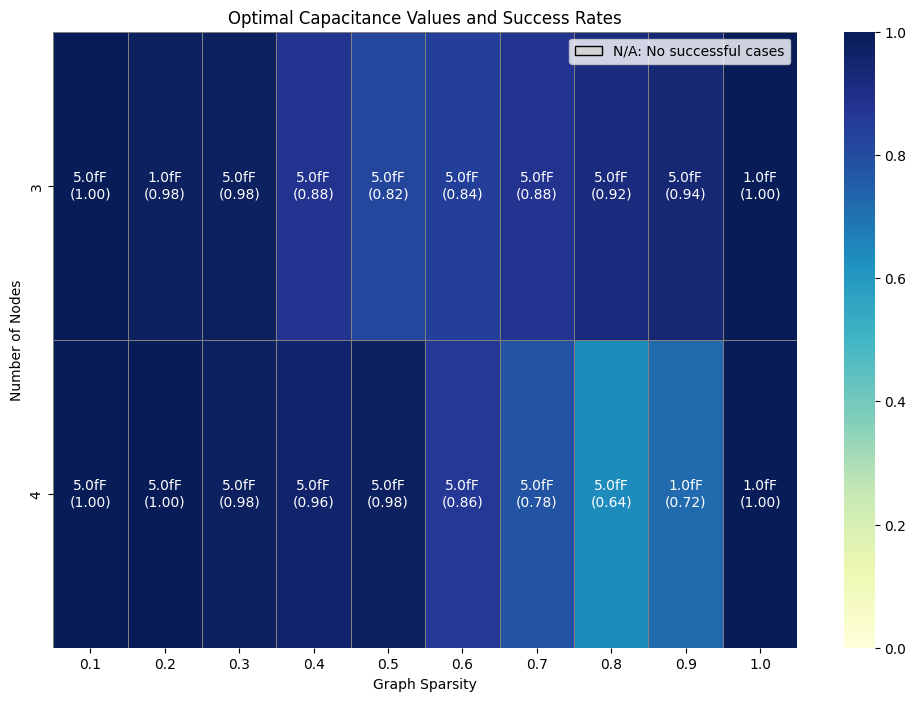

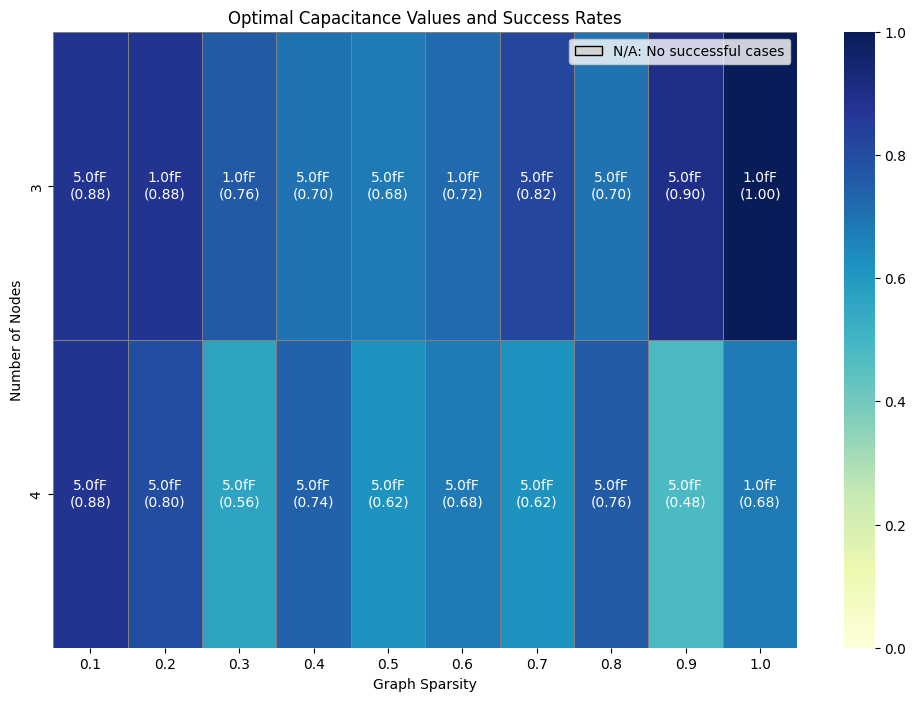

In [12]:
# Generate plots
plot_optimal_capacitance(results_fc['success_rates'],
                        results_fc['capacitance_values'],
                        results_fc['node_sizes'],
                        results_fc['sparsity_values'])

plot_optimal_capacitance(results_lattice['success_rates'],
                        results_lattice['capacitance_values'],
                        results_lattice['node_sizes'],
                        results_lattice['sparsity_values'])